In [92]:
"""
Asymmetric Penalty Binary Cross-Entropy Loss

A novel loss function that combines label smoothing with asymmetric penalties:
- Minimum at smoothed label (not at hard labels)
- Steeper penalty toward opposing class
- Gentler penalty toward actual class

Mathematical Foundation:
1. Standard BCE: -[y*log(p) + (1-y)*log(1-p)]
2. Label Smoothing: Replace y with y_smooth = y*(1-ε) + (1-y)*ε
3. Asymmetric Penalty: Add directional penalties around the smoothed optimum
4. Focal-loss
5. Binary Active-Negative Loss (ANL-CE)
"""

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.losses import BinaryFocalCrossentropy

In [93]:

def standard_binary_crossentropy(y_true, y_pred):
    """Standard Binary Cross-Entropy Loss"""
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
    return -tf.reduce_mean(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))

def label_smoothing_binary_crossentropy(y_true, y_pred, label_smoothing=0.1):
    """Binary Cross-Entropy with Standard Label Smoothing"""
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

    # Apply label smoothing: y=1 → 1-ε, y=0 → ε
    y_smooth = y_true * (1 - label_smoothing) + (1 - y_true) * label_smoothing

    return -tf.reduce_mean(y_smooth * tf.math.log(y_pred) + (1 - y_smooth) * tf.math.log(1 - y_pred))

def asymmetric_penalty_binary_crossentropy(y_true, y_pred, label_smoothing=0.1,
                                           asymmetry_strength_pos=0.5, asymmetry_strength_neg=0.5):
    """
    Asymmetric Penalty Binary Cross-Entropy Loss with separate asymmetry for each class

    Features:
    - Minimum at smoothed label: p = 1-ε (true=1), p = ε (true=0)
    - Steeper penalty toward opposing class
    - Gentler penalty toward actual class
    - Separate asymmetry control for positive and negative classes

    Args:
        y_true: Ground truth binary labels
        y_pred: Predicted probabilities
        label_smoothing: Smoothing parameter ε (0.05-0.15 recommended)
        asymmetry_strength_pos: Controls penalty asymmetry for positive class (0.3-0.8 recommended)
        asymmetry_strength_neg: Controls penalty asymmetry for negative class (0.3-0.8 recommended)
    """
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

    # Base with label smoothing
    y_smooth = y_true * (1 - label_smoothing) + (1 - y_true) * label_smoothing
    base_loss = -(y_smooth * tf.math.log(y_pred) + (1 - y_smooth) * tf.math.log(1 - y_pred))

    # Optimal prediction points
    optimal = y_true * (1 - label_smoothing) + (1 - y_true) * label_smoothing
    base_loss_optimal = -(y_smooth * tf.math.log(optimal) + (1 - y_smooth) * tf.math.log(1 - optimal))

    # Normalize so min = 0
    base_loss = base_loss - base_loss_optimal

    # Distance from optimal points
    optimal_true1 = 1 - label_smoothing
    optimal_true0 = label_smoothing
    dist_from_optimal_true1 = tf.abs(y_pred - optimal_true1)
    dist_from_optimal_true0 = tf.abs(y_pred - optimal_true0)

    # Asymmetric penalties with separate strengths
    penalty_true1 = y_true * tf.where(
        y_pred < optimal_true1,
        asymmetry_strength_pos * dist_from_optimal_true1 ** 2,
        asymmetry_strength_pos * 0.3 * dist_from_optimal_true1 ** 2
    )

    penalty_true0 = (1 - y_true) * tf.where(
        y_pred > optimal_true0,
        asymmetry_strength_neg * dist_from_optimal_true0 ** 2,
        asymmetry_strength_neg * 0.3 * dist_from_optimal_true0 ** 2
    )

    total_loss = tf.reduce_mean(base_loss + penalty_true1 + penalty_true0)
    return tf.maximum(0.0, total_loss)

def binary_normalized_cross_entropy(y_true, y_pred):
    """Binary Normalized Cross Entropy (NCE)"""
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

    bce_numerator = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    log_prob_sum = -(tf.math.log(y_pred) + tf.math.log(1 - y_pred))
    log_prob_sum = tf.maximum(log_prob_sum, epsilon)

    nce = bce_numerator / log_prob_sum
    return tf.reduce_mean(nce)

def binary_normalized_negative_cross_entropy(y_true, y_pred, min_prob=1e-7):
    """Binary Normalized Negative Cross Entropy (NNCE)"""
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, min_prob, 1 - min_prob)

    A = -tf.math.log(tf.constant(min_prob))
    log_p_transform = A + tf.math.log(y_pred)
    log_1mp_transform = A + tf.math.log(1 - y_pred)

    neg_ce_numerator = y_true * log_p_transform + (1 - y_true) * log_1mp_transform
    neg_ce_denominator = tf.maximum(log_p_transform + log_1mp_transform, epsilon)

    nnce = 1 - (neg_ce_numerator / neg_ce_denominator)
    return tf.reduce_mean(nnce)

def binary_active_negative_loss(y_true, y_pred, alpha=1.0, beta=0.5, min_prob=1e-7):
    """Binary Active-Negative Loss (ANL-CE)"""
    active_loss = binary_normalized_cross_entropy(y_true, y_pred)
    negative_loss = binary_normalized_negative_cross_entropy(y_true, y_pred, min_prob)
    return alpha * active_loss + beta * negative_loss


In [94]:
# Numpy implementations
def np_standard_bce(y_true, p_values):
    """NumPy implementation for plotting"""
    return -(y_true * np.log(p_values) + (1 - y_true) * np.log(1 - p_values))

def np_label_smoothing_bce(y_true, p_values, label_smoothing=0.1):
    """NumPy implementation for plotting"""
    y_smooth = y_true * (1 - label_smoothing) + (1 - y_true) * label_smoothing
    return -(y_smooth * np.log(p_values) + (1 - y_smooth) * np.log(1 - p_values))

def np_asymmetric_penalty_bce(y_true, p_values, label_smoothing=0.1,
                              asymmetry_strength_pos=0.5, asymmetry_strength_neg=0.5):
    """NumPy implementation for plotting with separate asymmetry for each class"""
    # Base loss
    y_smooth = y_true * (1 - label_smoothing) + (1 - y_true) * label_smoothing
    base_loss = -(y_smooth * np.log(p_values) + (1 - y_smooth) * np.log(1 - p_values))

    # Optimal point
    optimal = (1 - label_smoothing) if y_true == 1 else label_smoothing
    base_loss_optimal = -(y_smooth * np.log(optimal) + (1 - y_smooth) * np.log(1 - optimal))

    # Normalize so minimum = 0
    base_loss = base_loss - base_loss_optimal

    # Asymmetric penalty with class-specific strength
    dist = np.abs(p_values - optimal)
    if y_true == 1:
        penalty = np.where(
            p_values < optimal,  # Toward opposing class (0)
            asymmetry_strength_pos * dist ** 2,
            asymmetry_strength_pos * 0.3 * dist ** 2
        )
    else:
        penalty = np.where(
            p_values > optimal,  # Toward opposing class (1)
            asymmetry_strength_neg * dist ** 2,
            asymmetry_strength_neg * 0.3 * dist ** 2
        )

    return np.maximum(0.0, base_loss + penalty)


def np_focal_loss(y_true, p_values, gamma=2.0, alpha=0.25, label_smoothing=0.0, apply_class_balancing=False):
    """Binary Focal Loss using tf.keras.losses.BinaryFocalCrossentropy (NumPy-friendly)."""
    p = np.clip(np.asarray(p_values, dtype=np.float32), 1e-7, 1 - 1e-7)
    p_tf = tf.convert_to_tensor(p, dtype=tf.float32)
    p_tf = tf.reshape(p_tf, (-1, 1))
    y_tf = tf.fill(tf.shape(p_tf), float(y_true))
    loss_fn = BinaryFocalCrossentropy(
        gamma=gamma,
        alpha=alpha,
        from_logits=False,
        label_smoothing=label_smoothing,
        reduction=tf.keras.losses.Reduction.NONE,
        apply_class_balancing=apply_class_balancing
    )
    losses = loss_fn(y_tf, p_tf)  # shape: (N,)
    return tf.reshape(losses, (-1,)).numpy()

def np_gradient_focal_loss(y_true, p_values, gamma=2.0, alpha=0.25, label_smoothing=0.0, apply_class_balancing=False):
    """Gradient of Binary Focal Loss w.r.t. predicted probability p using autodiff."""
    p = np.clip(np.asarray(p_values, dtype=np.float32), 1e-7, 1 - 1e-7)
    p_tf = tf.convert_to_tensor(p, dtype=tf.float32)
    p_tf = tf.reshape(p_tf, (-1, 1))
    p_var = tf.Variable(p_tf)
    y_tf = tf.fill(tf.shape(p_var), float(y_true))
    loss_fn = BinaryFocalCrossentropy(
        gamma=gamma,
        alpha=alpha,
        from_logits=False,
        label_smoothing=label_smoothing,
        reduction=tf.keras.losses.Reduction.NONE,
        apply_class_balancing=apply_class_balancing
    )
    with tf.GradientTape() as tape:
        tape.watch(p_var)
        losses = loss_fn(y_tf, p_var)  # per-sample loss (N,)
        loss_sum = tf.reduce_sum(losses)
    grad = tape.gradient(loss_sum, p_var)
    return tf.reshape(grad, (-1,)).numpy()



def np_binary_normalized_cross_entropy(y_true, p_values):
    """NumPy implementation of binary NCE for plotting"""
    p_values = np.clip(p_values, 1e-7, 1 - 1e-7)

    bce_numerator = -(y_true * np.log(p_values) + (1 - y_true) * np.log(1 - p_values))
    log_prob_sum = -(np.log(p_values) + np.log(1 - p_values))
    log_prob_sum = np.maximum(log_prob_sum, 1e-7)

    return bce_numerator / log_prob_sum

def np_binary_normalized_negative_cross_entropy(y_true, p_values, min_prob=1e-7):
    """NumPy implementation of binary NNCE for plotting"""
    p_values = np.clip(p_values, min_prob, 1 - min_prob)

    A = -np.log(min_prob)
    log_p_transform = A + np.log(p_values)
    log_1mp_transform = A + np.log(1 - p_values)

    neg_ce_numerator = y_true * log_p_transform + (1 - y_true) * log_1mp_transform
    neg_ce_denominator = np.maximum(log_p_transform + log_1mp_transform, 1e-7)

    return 1 - (neg_ce_numerator / neg_ce_denominator)

def np_binary_active_negative_loss(y_true, p_values, alpha=1.0, beta=0.5, min_prob=1e-7):
    """NumPy implementation of binary ANL for plotting"""
    active_loss = np_binary_normalized_cross_entropy(y_true, p_values)
    negative_loss = np_binary_normalized_negative_cross_entropy(y_true, p_values, min_prob)
    return alpha * active_loss + beta * negative_loss

In [95]:
# Gradient calculation
def np_gradient_standard_bce(y_true, p_values):
  """Gradient of standard BCE w.r.t. predicted probability"""
  return -(y_true / p_values) + (1 - y_true) / (1 - p_values)

def np_gradient_label_smoothing_bce(y_true, p_values, label_smoothing=0.1):
  """Gradient of label smoothing BCE w.r.t. predicted probability"""
  y_smooth = y_true * (1 - label_smoothing) + (1 - y_true) * label_smoothing
  return -(y_smooth / p_values) + (1 - y_smooth) / (1 - p_values)

def np_gradient_asymmetric_penalty_bce(y_true, p_values, label_smoothing=0.1,
                                       asymmetry_strength_pos=0.5, asymmetry_strength_neg=0.5):
    """Gradient of asymmetric penalty BCE w.r.t. predicted probability with separate asymmetry"""
    # Base gradient
    y_smooth = y_true * (1 - label_smoothing) + (1 - y_true) * label_smoothing
    base_grad = -(y_smooth / p_values) + (1 - y_smooth) / (1 - p_values)

    # Optimal point
    optimal = (1 - label_smoothing) if y_true == 1 else label_smoothing
    base_grad_optimal = -(y_smooth / optimal) + (1 - y_smooth) / (1 - optimal)
    base_grad = base_grad - base_grad_optimal  # normalize

    # Penalty gradient with class-specific strength
    if y_true == 1:
        penalty_grad = np.where(
            p_values < optimal,
            2 * asymmetry_strength_pos * (p_values - optimal),  # Strong gradient toward opposing
            2 * asymmetry_strength_pos * 0.3 * (p_values - optimal)  # Weak gradient toward actual
        )
    else:
        penalty_grad = np.where(
            p_values > optimal,
            2 * asymmetry_strength_neg * (p_values - optimal),
            2 * asymmetry_strength_neg * 0.3 * (p_values - optimal)
        )

    return base_grad + penalty_grad

def np_gradient_binary_nce(y_true, p_values):
  """Gradient of binary NCE w.r.t. predicted probability"""
  p_values = np.clip(p_values, 1e-7, 1 - 1e-7)

  f = -(y_true * np.log(p_values) + (1 - y_true) * np.log(1 - p_values))
  f_prime = -(y_true / p_values - (1 - y_true) / (1 - p_values))

  g = -(np.log(p_values) + np.log(1 - p_values))
  g_prime = -(1/p_values - 1/(1 - p_values))

  g = np.maximum(g, 1e-7)

  return (f_prime * g - f * g_prime) / (g * g)

def np_gradient_binary_nnce(y_true, p_values, min_prob=1e-7):
  """Gradient of binary NNCE w.r.t. predicted probability"""
  p_values = np.clip(p_values, min_prob, 1 - min_prob)

  A = -np.log(min_prob)
  h = A + np.log(p_values)
  k = A + np.log(1 - p_values)

  h_prime = 1/p_values
  k_prime = -1/(1 - p_values)

  num = y_true * h + (1 - y_true) * k
  den = np.maximum(h + k, 1e-7)

  num_prime = y_true * h_prime + (1 - y_true) * k_prime
  den_prime = h_prime + k_prime

  ratio_prime = (num_prime * den - num * den_prime) / (den * den)
  return -ratio_prime

def np_gradient_binary_anl(y_true, p_values, alpha=1.0, beta=0.5, min_prob=1e-7):
  """Gradient of binary ANL w.r.t. predicted probability"""
  grad_nce = np_gradient_binary_nce(y_true, p_values)
  grad_nnce = np_gradient_binary_nnce(y_true, p_values, min_prob)

  return alpha * grad_nce + beta * grad_nnce

In [96]:
def plot_loss_comparison(label_smoothing=0.1, asymmetry_strength_pos=0.5, asymmetry_strength_neg=0.5, focal_gamma=2.0,
                         focal_alpha=0.25, anl_alpha=1.0, anl_beta=0.5, anl_min_prob=1e-7):
    """Create comprehensive comparison plots"""

    # Prediction probability range
    p_values = np.linspace(0.001, 0.999, 1000)

    # Calculate losses for both true classes
    losses = {}
    gradients = {}

    for y_true in [0, 1]:
        class_name = f"True={y_true}"

        # Calculate all loss types
        losses[class_name] = {
            'Standard BCE': np_standard_bce(y_true, p_values),
            'Label Smoothing': np_label_smoothing_bce(y_true, p_values, label_smoothing),
            'Asymmetric Penalty': np_asymmetric_penalty_bce(y_true, p_values, label_smoothing,
                                                            asymmetry_strength_pos=asymmetry_strength_pos,
                                                            asymmetry_strength_neg=asymmetry_strength_neg),
            'Focal Loss': np_focal_loss(y_true, p_values, gamma=focal_gamma, alpha=focal_alpha,
                                        label_smoothing=label_smoothing,
                                        apply_class_balancing=True if label_smoothing > 0 else False),
            'ANL-CE': np_binary_active_negative_loss(y_true, p_values, alpha=anl_alpha,
                                                    beta=anl_beta, min_prob=anl_min_prob)

            }

        # Calculate gradients
        gradients[class_name] = {
            'Standard BCE': np_gradient_standard_bce(y_true, p_values),
            'Label Smoothing': np_gradient_label_smoothing_bce(y_true, p_values, label_smoothing),
            'Asymmetric Penalty': np_gradient_asymmetric_penalty_bce(y_true, p_values, label_smoothing,
                                                                     asymmetry_strength_pos=asymmetry_strength_pos,
                                                                     asymmetry_strength_neg=asymmetry_strength_neg),
            'Focal Loss': np_gradient_focal_loss(y_true, p_values, gamma=focal_gamma, alpha=focal_alpha,
                                                 label_smoothing=label_smoothing,
                                                 apply_class_balancing=True if label_smoothing > 0 else False),
            'ANL-CE': np_gradient_binary_anl(y_true, p_values, alpha=anl_alpha, beta=anl_beta, min_prob=anl_min_prob)

            }

    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    colors = {
        'Standard BCE': 'black',
        'Label Smoothing': 'blue',
        'Asymmetric Penalty': 'red',
        'Focal Loss': 'green',
        'ANL-CE': 'purple'
    }
    styles = {
        'Standard BCE': '-',
        'Label Smoothing': '--',
        'Asymmetric Penalty': '-',
        'Focal Loss': '-.',
        'ANL-CE': ':'
    }
    markers = {
        'Standard BCE': 'o',
        'Label Smoothing': 's',
        'Asymmetric Penalty': '*',
        'Focal Loss': '^',
        'ANL-CE': 'D'
    }
    #--------------------------------------------------------------------------
    # Plot 1: Loss curves for True=1
    #--------------------------------------------------------------------------
    ax = axes[0, 0]

    for method_name, loss_values in losses['True=1'].items():
        ax.plot(p_values, loss_values, color=colors[method_name],
                linestyle=styles[method_name], linewidth=2.5, label=method_name, alpha=0.8)

        # Find and mark minimum
        min_idx = np.argmin(loss_values)
        min_p = p_values[min_idx]
        min_loss = loss_values[min_idx]

        marker = 'o' if method_name == 'Standard BCE' else ('s' if 'Label' in method_name else '*')
        ax.scatter(min_p, min_loss, color=colors[method_name], s=120, marker=marker,
                   edgecolor='white', linewidth=2, zorder=10)

        # Annotate minimum
        if method_name == 'Standard BCE':
            ax.annotate(f'Min: p=1.0', xy=(min_p, min_loss), xytext=(0.85, min_loss + 0.5),
                        arrowprops=dict(arrowstyle='->', color=colors[method_name]),
                        fontsize=10, ha='center')
        else:
            ax.annotate(f'Min: p={min_p:.2f}', xy=(min_p, min_loss), xytext=(min_p - 0.1, min_loss + 0.3),
                        arrowprops=dict(arrowstyle='->', color=colors[method_name]),
                        fontsize=10, ha='center')

    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Loss')
    ax.set_title('Loss Curves: True Label = 1')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 4)

    #--------------------------------------------------------------------------
    # Plot 2: Loss curves for True=0
    #--------------------------------------------------------------------------
    ax = axes[0, 1]

    for method_name, loss_values in losses['True=0'].items():
        ax.plot(p_values, loss_values, color=colors[method_name],
                linestyle=styles[method_name], linewidth=2.5, label=method_name, alpha=0.8)

        # Find and mark minimum
        min_idx = np.argmin(loss_values)
        min_p = p_values[min_idx]
        min_loss = loss_values[min_idx]

        marker = 'o' if method_name == 'Standard BCE' else ('s' if 'Label' in method_name else '*')
        ax.scatter(min_p, min_loss, color=colors[method_name], s=120, marker=marker,
                   edgecolor='white', linewidth=2, zorder=10)

        # Annotate minimum
        if method_name == 'Standard BCE':
            ax.annotate(f'Min: p=0.0', xy=(min_p, min_loss), xytext=(0.15, min_loss + 0.5),
                        arrowprops=dict(arrowstyle='->', color=colors[method_name]),
                        fontsize=10, ha='center')
        else:
            ax.annotate(f'Min: p={min_p:.2f}', xy=(min_p, min_loss), xytext=(min_p + 0.1, min_loss + 0.3),
                        arrowprops=dict(arrowstyle='->', color=colors[method_name]),
                        fontsize=10, ha='center')

    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Loss')
    ax.set_title('Loss Curves: True Label = 0')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 4)

    #--------------------------------------------------------------------------
    # Plot 3: Gradients for True=1
    #--------------------------------------------------------------------------
    ax = axes[1, 0]

    # Clip gradients for better visualization
    p_clip = p_values[(p_values > 0.05) & (p_values < 0.95)]

    for method_name, grad_values in gradients['True=1'].items():
        grad_clip = grad_values[(p_values > 0.05) & (p_values < 0.95)]

        ax.plot(p_clip, grad_clip, color=colors[method_name],
                linestyle=styles[method_name], linewidth=2.5, label=method_name, alpha=0.8)

    ax.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Gradient')
    ax.set_title('Gradients: True Label = 1')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-20, 20)

    # Add annotations for gradient interpretation
    ax.annotate('Steep negative:\nStrong pull toward 1',
                xy=(0.1, -15), xytext=(0.2, -18),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                fontsize=9, ha='center', color='red')


    #--------------------------------------------------------------------------
    # Plot 4: Gradients for True=0
    #--------------------------------------------------------------------------
    ax = axes[1, 1]

    for method_name, grad_values in gradients['True=0'].items():
        grad_clip = grad_values[(p_values > 0.05) & (p_values < 0.95)]

        ax.plot(p_clip, grad_clip, color=colors[method_name],
                linestyle=styles[method_name], linewidth=2.5, label=method_name, alpha=0.8)

    ax.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Gradient')
    ax.set_title('Gradients: True Label = 0')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-20, 20)

    ax.annotate('Steep positive:\nStrong pull from 0',
                xy=(0.9, 15), xytext=(0.9, 18),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                fontsize=9, ha='center', color='red')

    plt.tight_layout()
    plt.show()

    # Print summary of key characteristics
    print("=" * 80)
    print("ASYMMETRIC PENALTY BINARY CROSS-ENTROPY ANALYSIS")
    print("=" * 80)

    print(f"\nPARAMETERS:")
    print(f"  Label smoothing (ε): {label_smoothing}")
    print(f"  Asymmetry strength_pos: {asymmetry_strength_pos}")
    print(f"  Asymmetry strength_neg: {asymmetry_strength_neg}")
    print(f"  Focal gamma: {focal_gamma}")
    print(f"  Focal alpha: {focal_alpha}")

    print(f"\nMINIMA LOCATIONS:")
    for y_true in [0, 1]:
        class_name = f"True={y_true}"
        print(f"  {class_name}:")
        for method_name, loss_values in losses[class_name].items():
            min_idx = np.argmin(loss_values)
            min_p = p_values[min_idx]
            print(f"    {method_name}: p = {min_p:.3f}")

    print(f"\nKEY CHARACTERISTICS:")
    print(f"✅ Standard BCE: Minima at hard labels (0, 1)")
    print(f"✅ Label Smoothing: Minima at smoothed labels ({label_smoothing:.1f}, {1 - label_smoothing:.1f})")
    print(f"✅ Asymmetric Penalty: Minima at smoothed labels + asymmetric penalties")
    print(f"   • Steeper penalty toward opposing class")
    print(f"   • Gentler penalty toward actual class")
    print(f"   • Better regularization properties")
    print(f"✅ Focal Loss: Focuses learning on hard examples via (1-p_t)^γ weighting")
    print(f"✅ ANL-CE: Combines Normalized CE + Normalized Negative CE")
    print(f"   • NCE normalizes BCE by log probability sum for stable gradients")
    print(f"   • NNCE provides regularization against uniform distribution")
    print(f"   • Robust to label noise and provides better calibration")
    print("=" * 80)


Asymmetric Penalty Binary Cross-Entropy Loss

Sample Loss Calculations:
Standard BCE: 0.2310
Label Smoothing BCE: 0.3832
Asymmetric Penalty BCE: 0.0982
Focal Loss (TF/Keras): 0.0113
Binary ANL-CE: 0.3735

Generating comprehensive visualization...


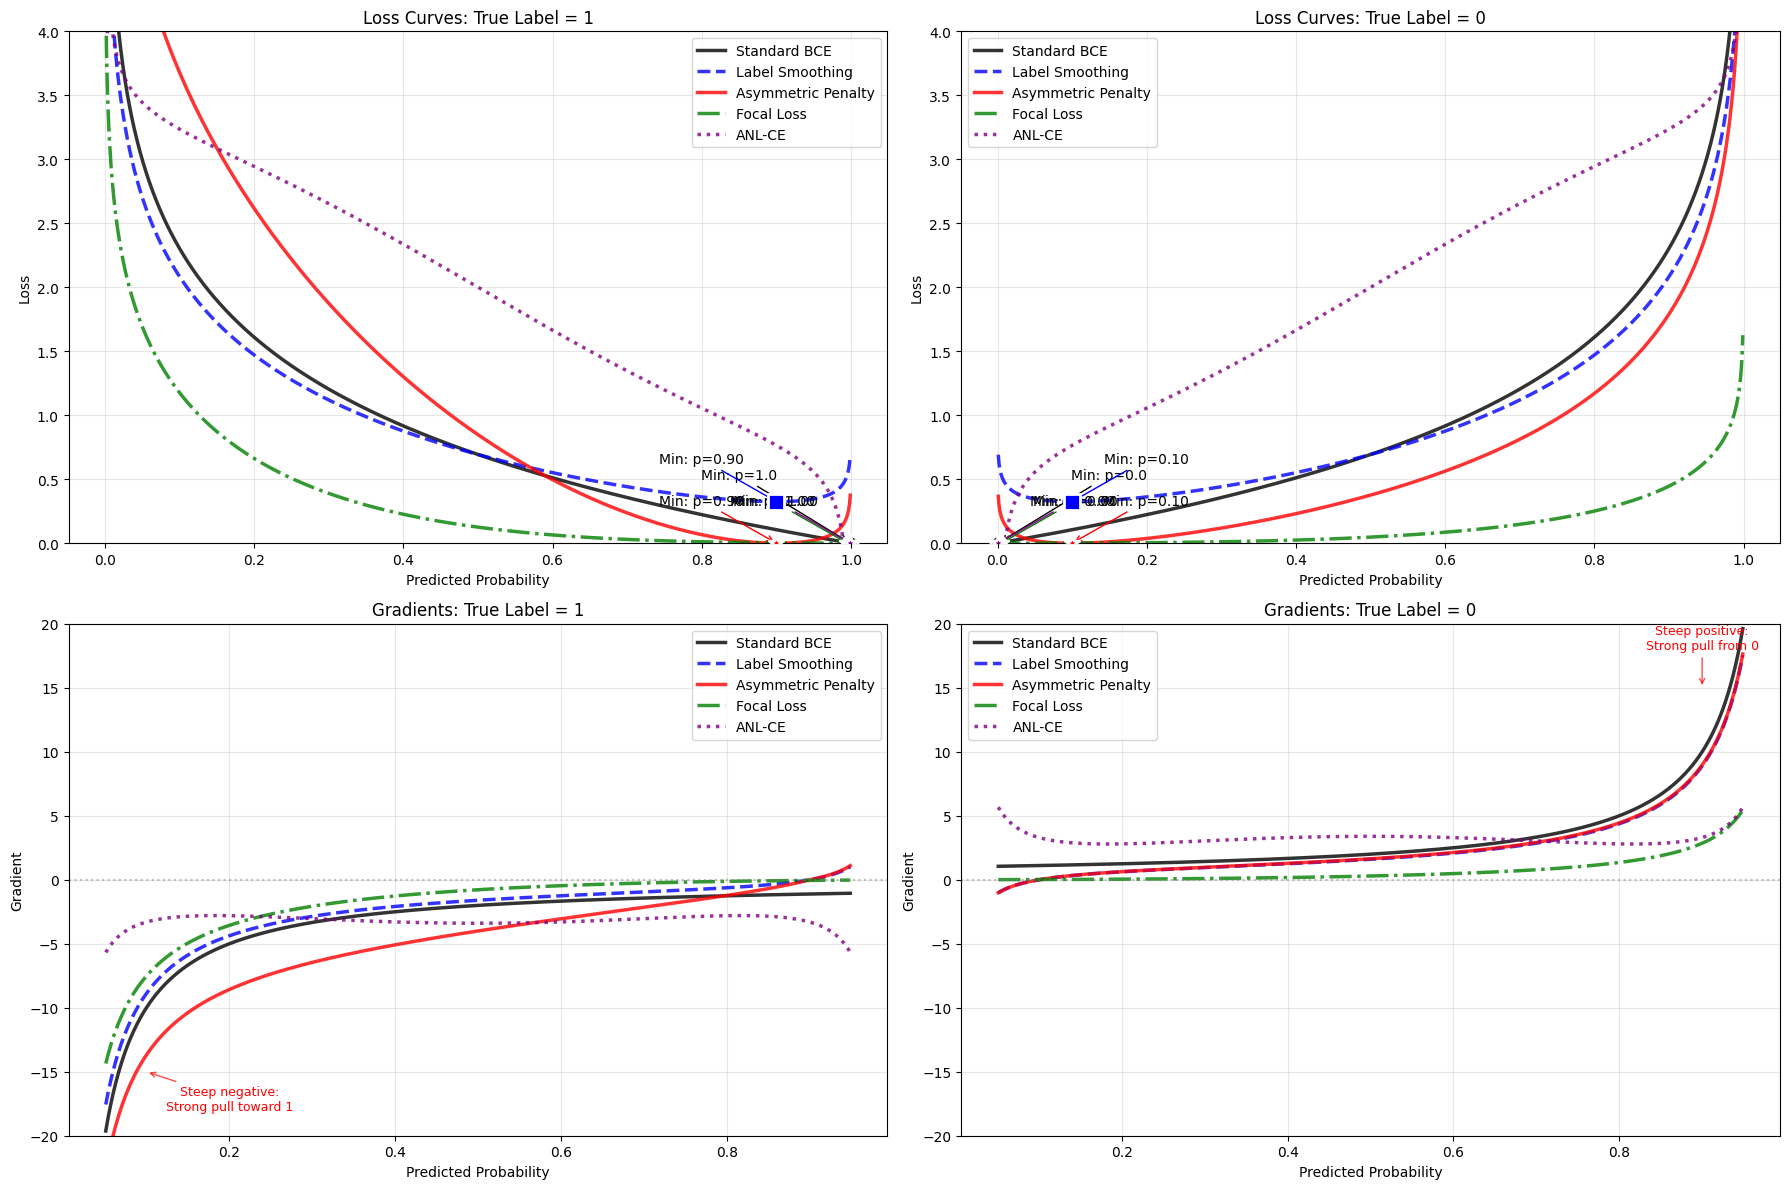

ASYMMETRIC PENALTY BINARY CROSS-ENTROPY ANALYSIS

PARAMETERS:
  Label smoothing (ε): 0.1
  Asymmetry strength_pos: 3.0
  Asymmetry strength_neg: 0.05
  Focal gamma: 2.0
  Focal alpha: 0.75

MINIMA LOCATIONS:
  True=0:
    Standard BCE: p = 0.001
    Label Smoothing: p = 0.100
    Asymmetric Penalty: p = 0.100
    Focal Loss: p = 0.005
    ANL-CE: p = 0.001
  True=1:
    Standard BCE: p = 0.999
    Label Smoothing: p = 0.900
    Asymmetric Penalty: p = 0.900
    Focal Loss: p = 0.995
    ANL-CE: p = 0.999

KEY CHARACTERISTICS:
✅ Standard BCE: Minima at hard labels (0, 1)
✅ Label Smoothing: Minima at smoothed labels (0.1, 0.9)
✅ Asymmetric Penalty: Minima at smoothed labels + asymmetric penalties
   • Steeper penalty toward opposing class
   • Gentler penalty toward actual class
   • Better regularization properties
✅ Focal Loss: Focuses learning on hard examples via (1-p_t)^γ weighting
✅ ANL-CE: Combines Normalized CE + Normalized Negative CE
   • NCE normalizes BCE by log probability s

In [97]:

if __name__ == "__main__":
    # Example usage
    print("Asymmetric Penalty Binary Cross-Entropy Loss")
    print("=" * 50)

    # Test with sample data
    y_true = tf.constant([1.0, 0.0, 1.0, 0.0])
    y_pred = tf.constant([0.9, 0.1, 0.7, 0.3])

    print("\nSample Loss Calculations:")
    print(f"Standard BCE: {standard_binary_crossentropy(y_true, y_pred).numpy():.4f}")
    print(f"Label Smoothing BCE: {label_smoothing_binary_crossentropy(y_true, y_pred, 0.10).numpy():.4f}")
    print(f"Asymmetric Penalty BCE: {asymmetric_penalty_binary_crossentropy(y_true, y_pred, 0.10, 3., 1.).numpy():.4f}")
    fl = BinaryFocalCrossentropy(gamma=2.0, alpha=0.25, from_logits=False, label_smoothing=0.10,
                                 apply_class_balancing=True)
    print(f"Focal Loss (TF/Keras): {fl(y_true, y_pred).numpy():.4f}")
    print(f"Binary ANL-CE: {binary_active_negative_loss(y_true, y_pred, alpha=1.0, beta=0.5).numpy():.4f}")

    print("\nGenerating comprehensive visualization...")
    plot_loss_comparison(label_smoothing=0.1, asymmetry_strength_pos=3.0, asymmetry_strength_neg=0.05, focal_gamma=2.0,
                         focal_alpha=0.75, anl_alpha=2.0, anl_beta=2., anl_min_prob=0.01)

In [98]:
# Generate dummy data
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_redundant=5, random_state=42)

# Introduce mislabeling
mislabeled_percentage = 0.2
n_mislabeled = int(len(y) * mislabeled_percentage)
mislabeled_indices = np.random.choice(len(y), n_mislabeled, replace=False)
y_mislabeled = np.copy(y)
y_mislabeled[mislabeled_indices] = 1 - y_mislabeled[mislabeled_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y_mislabeled, test_size=0.2, random_state=42)

print("Dummy data generated with mislabeling.")
print(f"Original labels shape: {y.shape}")
print(f"Mislabeled labels shape: {y_mislabeled.shape}")
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Dummy data generated with mislabeling.
Original labels shape: (1000,)
Mislabeled labels shape: (1000,)
Training data shape: (800, 20), (800,)
Testing data shape: (200, 20), (200,)


In [99]:
def load_data_with_categories(noise_rate=0.2):
    """Load breast cancer data and create sample categories for analysis"""
    from sklearn.datasets import load_breast_cancer
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler

    # Load and prepare data
    data = load_breast_cancer()
    X, y = data.data, data.target

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train_orig, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    # Introduce mislabeling and track categories
    np.random.seed(42)
    n_mislabel = int(len(y_train_orig) * noise_rate)
    mislabel_indices = np.random.choice(len(y_train_orig), n_mislabel, replace=False)

    y_train_noisy = y_train_orig.copy()
    y_train_noisy[mislabel_indices] = 1 - y_train_noisy[mislabel_indices]

    # Create sample categories
    categories = {
        'true_pos': (y_train_orig == 1) & (~np.isin(range(len(y_train_orig)), mislabel_indices)),
        'true_neg': (y_train_orig == 0) & (~np.isin(range(len(y_train_orig)), mislabel_indices)),
        'mislabel_to_pos': (y_train_orig == 0) & (np.isin(range(len(y_train_orig)), mislabel_indices)),
        'mislabel_to_neg': (y_train_orig == 1) & (np.isin(range(len(y_train_orig)), mislabel_indices))
    }

    print(f"Sample categories (noise rate: {noise_rate:.0%}):")
    for cat_name, mask in categories.items():
        print(f"  {cat_name}: {np.sum(mask)} samples")

    return X_train, X_test, y_train_noisy, y_test, categories


--- Training Standard BCE ---


/home/amirreza/miniforge3/envs/py313/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


--- Training Label Smoothing ---


/home/amirreza/miniforge3/envs/py313/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


--- Training Asymmetric Penalty ---


/home/amirreza/miniforge3/envs/py313/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


--- Training Focal Loss ---


/home/amirreza/miniforge3/envs/py313/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


--- Training ANL-CE ---


/home/amirreza/miniforge3/envs/py313/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


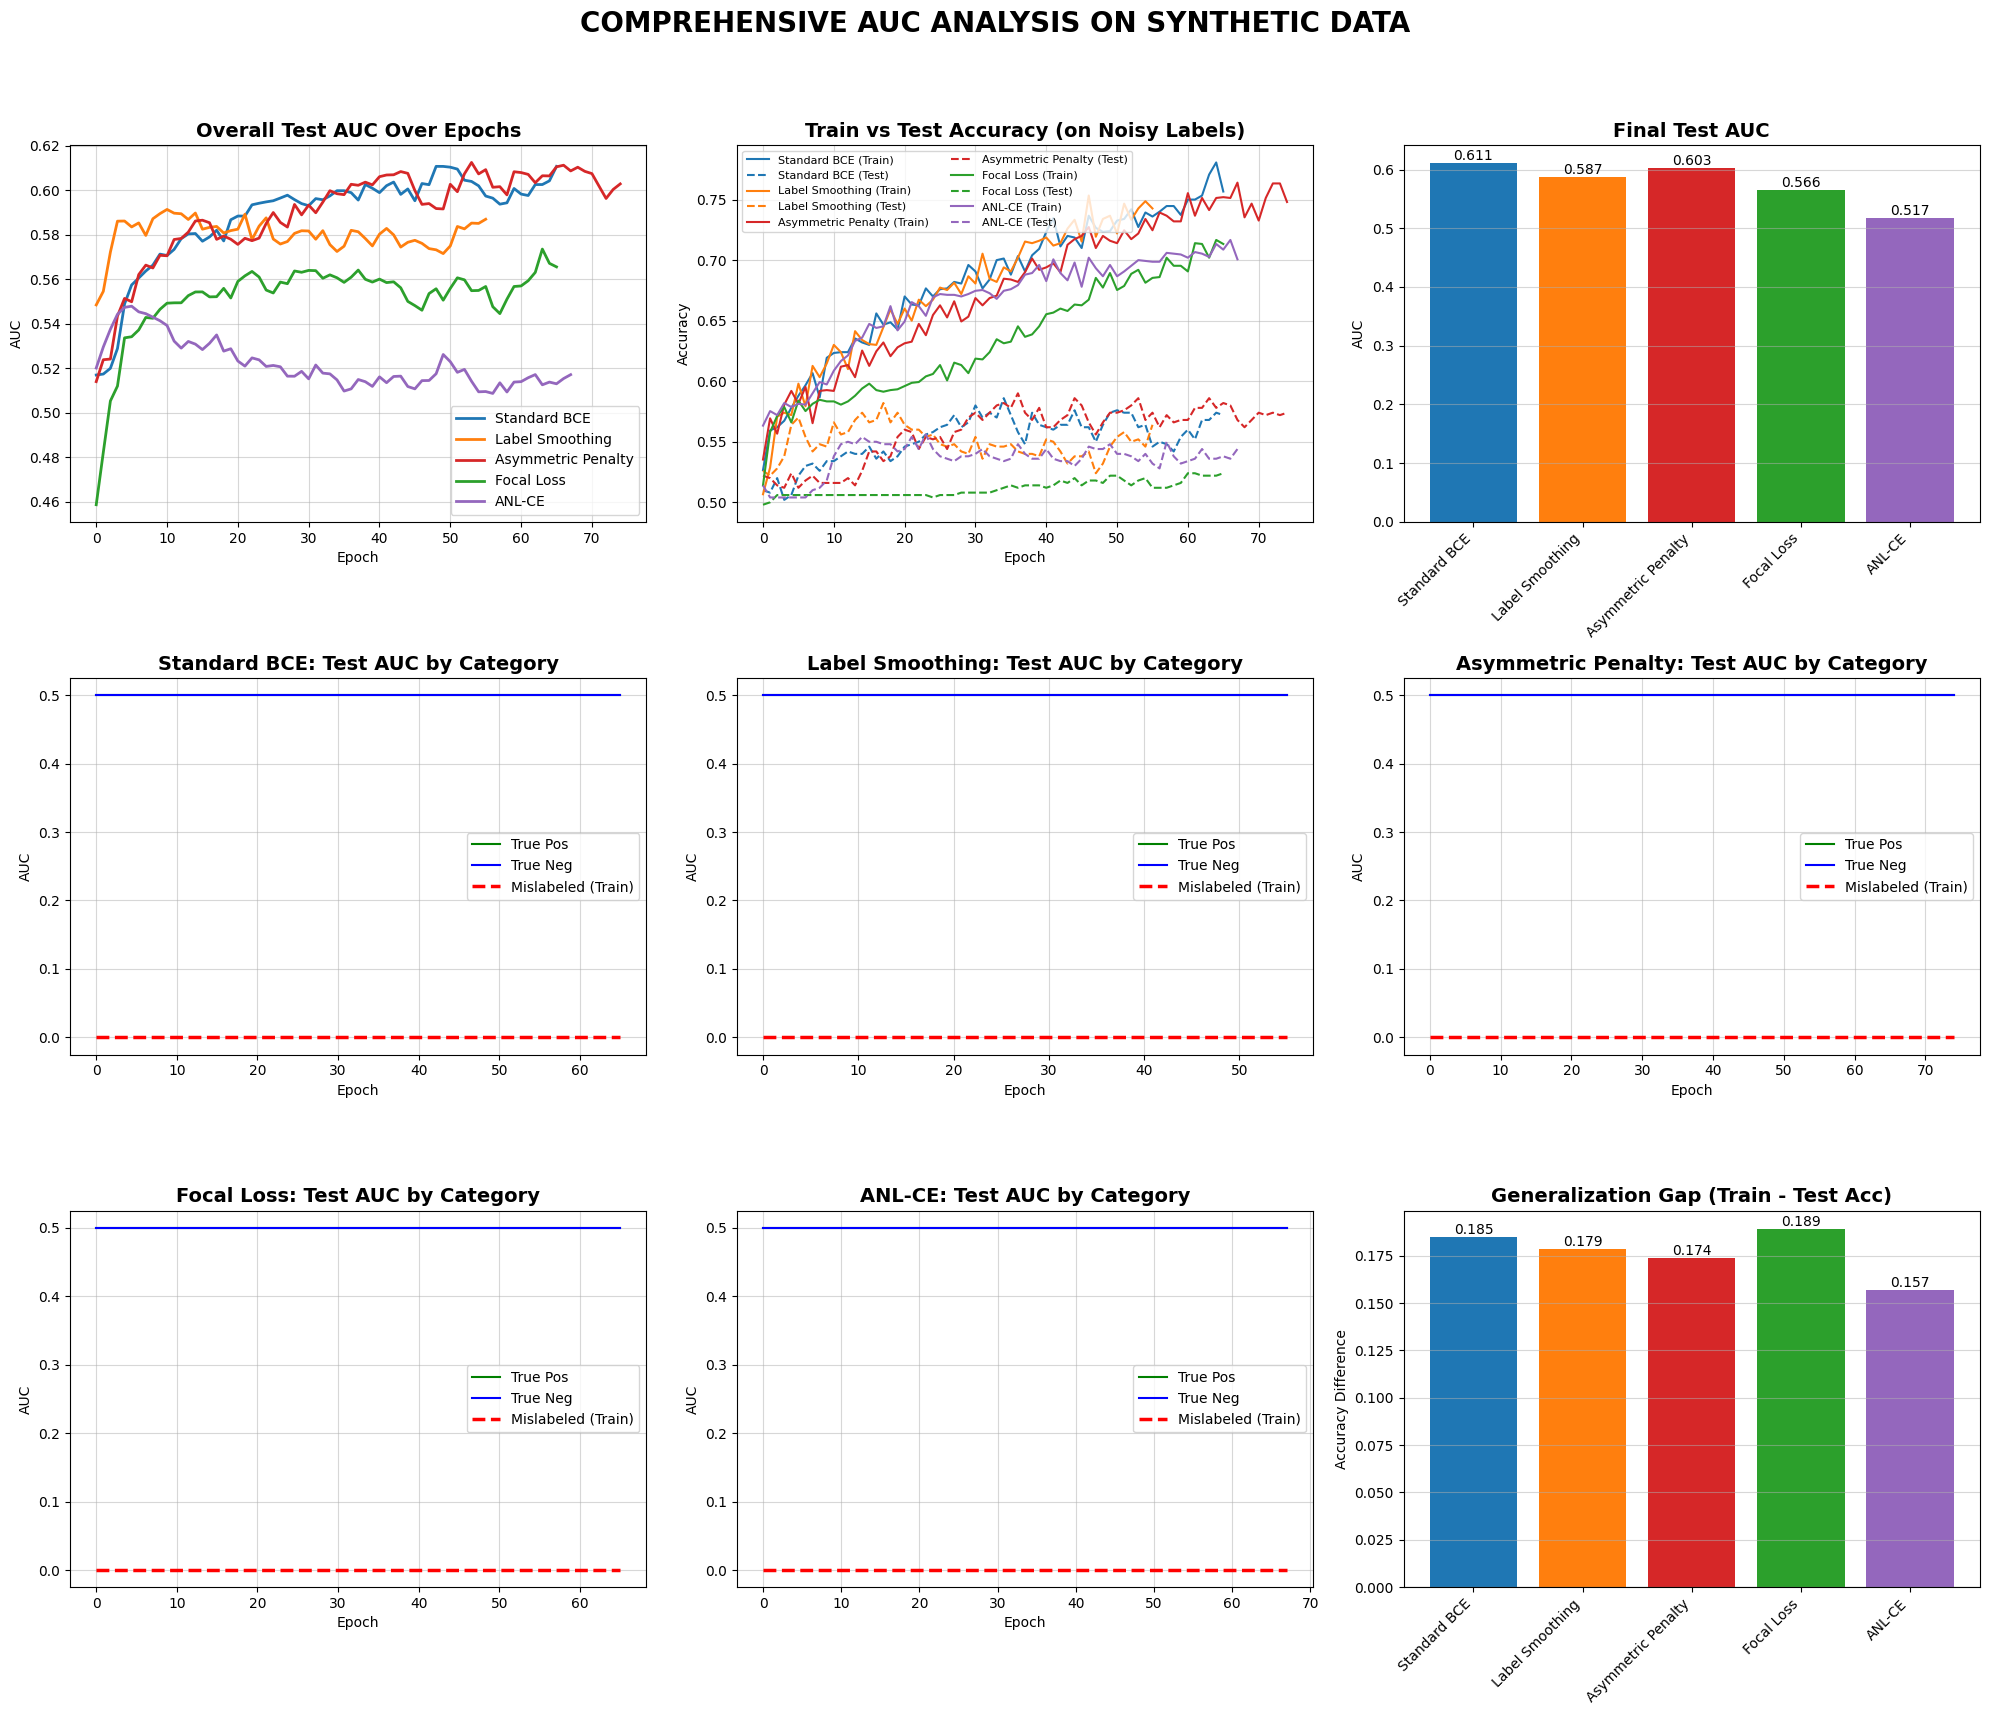

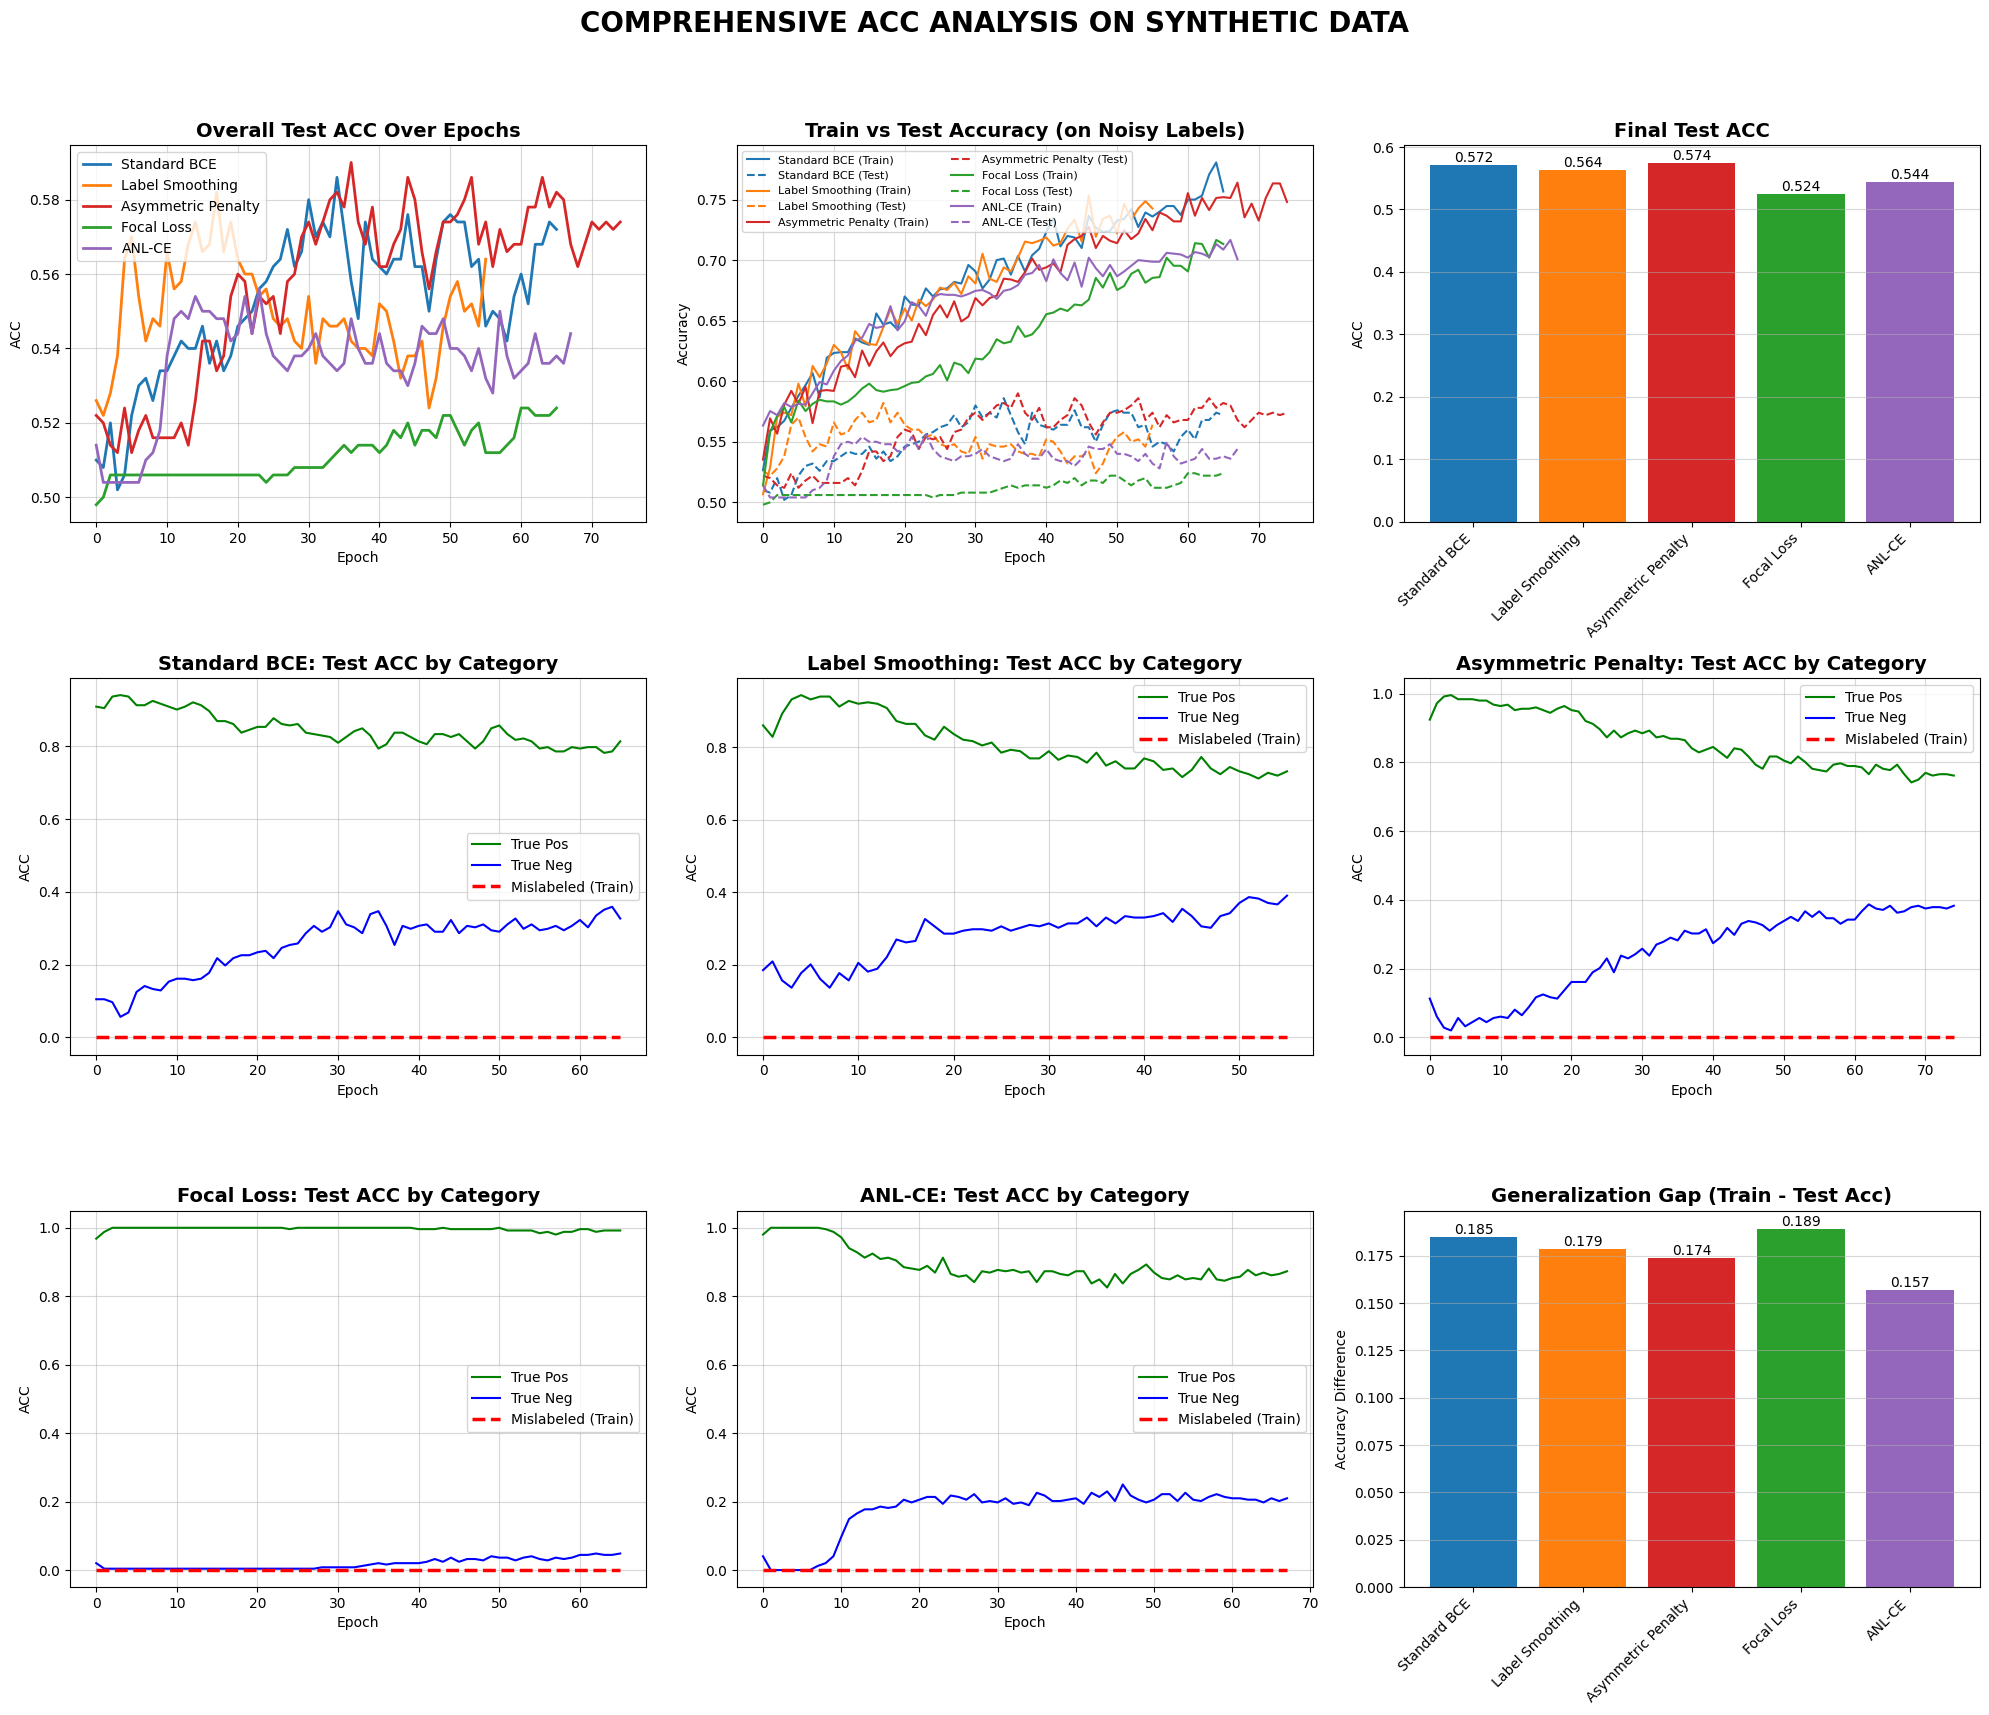


FINAL PERFORMANCE SUMMARY (ACCURACY & AUC)
     Loss Function  Final Test AUC  Final Test ACC  Generalization Gap  ACC on Mislabeled
      Standard BCE        0.610695           0.572            0.184667           0.182090
Asymmetric Penalty        0.602839           0.574            0.174000           0.137313
   Label Smoothing        0.586966           0.564            0.178667           0.170149
        Focal Loss        0.565572           0.524            0.189333           0.289552
            ANL-CE        0.517169           0.544            0.156667           0.256716
--------------------------------------------------------------------------------
BEST PERFORMERS:
  Highest AUC: Standard BCE (0.6107)
  Highest ACC: Asymmetric Penalty (0.5740)
  Best Generalization (Lowest Gap): ANL-CE (0.1567)
  Best at Correcting Noise (ACC on Mislabeled): Focal Loss (0.2896)


In [100]:
# Enhanced Loss Function Comparison with Epoch Tracking (ACC/AUC Focus)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.losses import BinaryFocalCrossentropy
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
import pandas as pd


class PerClassMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train_original, categories_train, X_test, y_test_original, categories_test):
        super().__init__()
        self.X_train, self.y_train_original, self.categories_train = X_train, y_train_original, categories_train
        self.X_test, self.y_test_original, self.categories_test = X_test, y_test_original, categories_test
        self.epoch_metrics = {
            'test_auc_overall': [], 'test_acc_overall': [], 'train_auc_true_pos': [], 'train_acc_true_pos': [],
            'train_auc_true_neg': [], 'train_acc_true_neg': [], 'train_auc_mislabeled': [], 'train_acc_mislabeled': [],
            'test_auc_true_pos': [], 'test_acc_true_pos': [], 'test_auc_true_neg': [], 'test_acc_true_neg': [],
            'test_auc_mislabeled': [], 'test_acc_mislabeled': []}

    def _calculate_metrics_subset(self, y_true, y_pred):
        if len(y_true) == 0: return 0.0, 0.0
        acc = accuracy_score(y_true, y_pred.round())
        auc = 0.5 if len(np.unique(y_true)) < 2 else roc_auc_score(y_true, y_pred)
        return acc, auc

    def on_epoch_end(self, epoch, logs=None):
        y_pred_train = self.model.predict(self.X_train, verbose=0).flatten()
        y_pred_test = self.model.predict(self.X_test, verbose=0).flatten()
        acc_overall, auc_overall = self._calculate_metrics_subset(self.y_test_original, y_pred_test)
        self.epoch_metrics['test_acc_overall'].append(acc_overall); self.epoch_metrics['test_auc_overall'].append(auc_overall)
        masks = {
            'train': {'true_pos': self.categories_train['true_pos'], 'true_neg': self.categories_train['true_neg'], 'mislabeled': self.categories_train['mislabel_to_pos'] | self.categories_train['mislabel_to_neg']},
            'test': {'true_pos': self.categories_test['true_pos'], 'true_neg': self.categories_test['true_neg'], 'mislabeled': self.categories_test['mislabeled']}}
        for data_split, split_masks in masks.items():
            y_pred = y_pred_train if data_split == 'train' else y_pred_test
            y_true_original = self.y_train_original if data_split == 'train' else self.y_test_original
            for cat_name, mask in split_masks.items():
                acc, auc = self._calculate_metrics_subset(y_true_original[mask], y_pred[mask])
                self.epoch_metrics[f'{data_split}_acc_{cat_name}'].append(acc); self.epoch_metrics[f'{data_split}_auc_{cat_name}'].append(auc)

def load_data_with_enhanced_categories(pos_noise_rate=0.15, neg_noise_rate=0.30):
    """
    Load a challenging synthetic dataset with controlled complexity and noise.
    """
    # 1. Generate the synthetic dataset
    X, y = make_classification(
        n_samples=2000,
        n_features=40,       # features
        n_informative=15,    # Not all features are useful
        n_redundant=10,      # Some are redundant
        n_clusters_per_class=15, # complex structure
        class_sep=0.9,       # Less separation between classes
        flip_y=0.1,         # 10% inherent random noise
        random_state=999
    )

    # 2. Standard preprocessing and data splitting
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train_orig, y_test_orig = train_test_split(
        X_scaled, y, test_size=0.25, random_state=999, stratify=y)

    # 3. Apply structured label noise (same logic as before)
    np.random.seed(999)
    pos_indices_train = np.where(y_train_orig == 1)[0]
    neg_indices_train = np.where(y_train_orig == 0)[0]
    n_mislabel_pos_train = int(len(pos_indices_train) * pos_noise_rate)
    n_mislabel_neg_train = int(len(neg_indices_train) * neg_noise_rate)
    mislabel_pos_indices_train = np.random.choice(pos_indices_train, n_mislabel_pos_train, replace=False)
    mislabel_neg_indices_train = np.random.choice(neg_indices_train, n_mislabel_neg_train, replace=False)
    mislabel_indices_train = np.concatenate([mislabel_pos_indices_train, mislabel_neg_indices_train])
    y_train_noisy = y_train_orig.copy()
    y_train_noisy[mislabel_indices_train] = 1 - y_train_noisy[mislabel_indices_train]
    categories_train = {
        'true_pos': (y_train_orig == 1) & (~np.isin(range(len(y_train_orig)), mislabel_indices_train)),
        'true_neg': (y_train_orig == 0) & (~np.isin(range(len(y_train_orig)), mislabel_indices_train)),
        'mislabel_to_pos': (y_train_orig == 0) & (np.isin(range(len(y_train_orig)), mislabel_indices_train)),
        'mislabel_to_neg': (y_train_orig == 1) & (np.isin(range(len(y_train_orig)), mislabel_indices_train))}

    # For simplicity, keep test set clean for this example, but noise could be added similarly
    y_test_noisy = y_test_orig.copy()
    categories_test = {
        'true_pos': y_test_orig == 1,
        'true_neg': y_test_orig == 0,
        'mislabeled': np.zeros(len(y_test_orig), dtype=bool)}

    return X_train, X_test, y_train_noisy, y_test_noisy, y_train_orig, y_test_orig, categories_train, categories_test

def create_enhanced_model():
    """Create a neural network model with the correct input shape."""
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='gelu', input_shape=(40,)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(32, activation='gelu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')])
    return model

# Training function
def train_enhanced_models(X_train, X_test, y_train, y_test, y_train_orig, y_test_orig, categories_train, categories_test):
    loss_functions = {
        'Standard BCE': {'fn': standard_binary_crossentropy, 'color': '#1f77b4'},
        'Label Smoothing': {'fn': lambda yt, yp: label_smoothing_binary_crossentropy(yt, yp, 0.1), 'color': '#ff7f0e'},
        'Asymmetric Penalty': {'fn': lambda yt, yp: asymmetric_penalty_binary_crossentropy(yt, yp, 0.1, 2.0, 0.8), 'color': '#d62728'},
        'Focal Loss': {'fn': BinaryFocalCrossentropy(gamma=2.0, alpha=0.75, label_smoothing=0.1, apply_class_balancing=True), 'color': '#2ca02c'},
        'ANL-CE': {'fn': lambda yt, yp: binary_active_negative_loss(yt, yp, alpha=2.0, beta=2.0, min_prob=0.01), 'color': '#9467bd'}}
    results = {}
    epochs = 75 # Increased epochs for the harder dataset
    for loss_name, loss_info in loss_functions.items():
        print(f"--- Training {loss_name} ---")
        model = create_enhanced_model()
        per_class_callback = PerClassMetricsCallback(X_train, y_train_orig, categories_train, X_test, y_test_orig, categories_test)
        model.compile(optimizer='adam', loss=loss_info['fn'], metrics=['accuracy'])
        history = model.fit(
            X_train, y_train, epochs=epochs, batch_size=32, verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[per_class_callback, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)])
        results[loss_name] = {'history': history, 'per_class_metrics': per_class_callback.epoch_metrics, 'color': loss_info['color']}
    return results

# Plotting and summary functions
def plot_metric_analysis(results, metric_name='AUC'):
    metric_key_overall = f'test_{metric_name.lower()}_overall'
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 18))
    fig.suptitle(f'COMPREHENSIVE {metric_name.upper()} ANALYSIS ON SYNTHETIC DATA', fontsize=20, fontweight='bold')
    ax1 = plt.subplot(3, 3, 1)
    for name, result in results.items():
        ax1.plot(result['per_class_metrics'][metric_key_overall], label=name, color=result['color'], linewidth=2)
    ax1.set_title(f'Overall Test {metric_name} Over Epochs', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel(metric_name); ax1.legend(); ax1.grid(True, alpha=0.5)
    ax2 = plt.subplot(3, 3, 2)
    for name, result in results.items():
        ax2.plot(result['history'].history['accuracy'], label=f'{name} (Train)', color=result['color'], linestyle='-')
        ax2.plot(result['history'].history['val_accuracy'], label=f'{name} (Test)', color=result['color'], linestyle='--')
    ax2.set_title('Train vs Test Accuracy (on Noisy Labels)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy'); ax2.legend(fontsize=8, ncol=2); ax2.grid(True, alpha=0.5)
    ax3 = plt.subplot(3, 3, 3)
    final_metrics = {name: res['per_class_metrics'][metric_key_overall][-1] for name, res in results.items()}
    bars = ax3.bar(final_metrics.keys(), final_metrics.values(), color=[res['color'] for res in results.values()])
    ax3.set_title(f'Final Test {metric_name}', fontsize=14, fontweight='bold')
    ax3.set_ylabel(metric_name)
    ax3.set_xticks(range(len(final_metrics))); ax3.set_xticklabels(final_metrics.keys(), rotation=45, ha="right")
    ax3.bar_label(bars, fmt='%.3f'); ax3.grid(True, axis='y', alpha=0.5)
    plot_positions = [(3, 3, 4), (3, 3, 5), (3, 3, 6), (3, 3, 7), (3, 3, 8)]
    for i, (name, result) in enumerate(results.items()):
        if i >= len(plot_positions): break
        ax = plt.subplot(*plot_positions[i])
        metrics = result['per_class_metrics']
        ax.plot(metrics[f'test_{metric_name.lower()}_true_pos'], label='True Pos', color='green')
        ax.plot(metrics[f'test_{metric_name.lower()}_true_neg'], label='True Neg', color='blue')
        ax.plot(metrics[f'test_{metric_name.lower()}_mislabeled'], label='Mislabeled (Train)', color='red', linewidth=2.5, linestyle='--')
        ax.set_title(f'{name}: Test {metric_name} by Category', fontsize=14, fontweight='bold')
        ax.set_xlabel('Epoch'); ax.set_ylabel(metric_name); ax.legend(); ax.grid(True, alpha=0.5)
    ax9 = plt.subplot(3, 3, 9)
    gaps = {name: res['history'].history['accuracy'][-1] - res['history'].history['val_accuracy'][-1] for name, res in results.items()}
    bars = ax9.bar(gaps.keys(), gaps.values(), color=[res['color'] for res in results.values()])
    ax9.set_title('Generalization Gap (Train - Test Acc)', fontsize=14, fontweight='bold')
    ax9.set_ylabel('Accuracy Difference')
    ax9.set_xticks(range(len(gaps))); ax9.set_xticklabels(gaps.keys(), rotation=45, ha="right")
    ax9.axhline(0, color='grey', linewidth=0.8); ax9.bar_label(bars, fmt='%.3f'); ax9.grid(True, axis='y', alpha=0.5)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

def print_final_metrics_summary(results):
    print("\n" + "="*80); print("FINAL PERFORMANCE SUMMARY (ACCURACY & AUC)"); print("="*80)
    summary_data = []
    for loss_name, result in results.items():
        metrics = result['per_class_metrics']
        history = result['history']
        final_auc = metrics['test_auc_overall'][-1]
        final_acc = metrics['test_acc_overall'][-1]
        generalization_gap = history.history['accuracy'][-1] - history.history['val_accuracy'][-1]
        mislabeled_perf = metrics['train_acc_mislabeled'][-1] # Switched to train mislabeled for summary as test is clean
        summary_data.append([loss_name, final_auc, final_acc, generalization_gap, mislabeled_perf])
    df_summary = pd.DataFrame(summary_data, columns=['Loss Function', 'Final Test AUC', 'Final Test ACC', 'Generalization Gap', 'ACC on Mislabeled'])
    df_summary = df_summary.sort_values(by='Final Test AUC', ascending=False)
    print(df_summary.to_string(index=False))
    print("-" * 80); print("BEST PERFORMERS:")
    print(f"  Highest AUC: {df_summary.iloc[0]['Loss Function']} ({df_summary.iloc[0]['Final Test AUC']:.4f})")
    print(f"  Highest ACC: {df_summary.loc[df_summary['Final Test ACC'].idxmax(), 'Loss Function']} ({df_summary['Final Test ACC'].max():.4f})")
    print(f"  Best Generalization (Lowest Gap): {df_summary.loc[df_summary['Generalization Gap'].idxmin(), 'Loss Function']} ({df_summary['Generalization Gap'].min():.4f})")
    print(f"  Best at Correcting Noise (ACC on Mislabeled): {df_summary.loc[df_summary['ACC on Mislabeled'].idxmax(), 'Loss Function']} ({df_summary['ACC on Mislabeled'].max():.4f})")
    print("="*80)

if __name__ == "__main__":
    X_train, X_test, y_train, y_test, y_train_orig, y_test_orig, categories_train, categories_test = \
        load_data_with_enhanced_categories(pos_noise_rate=0.15, neg_noise_rate=0.30)

    results = train_enhanced_models(X_train, X_test, y_train, y_test, y_train_orig, y_test_orig, categories_train, categories_test)

    plot_metric_analysis(results, metric_name='AUC')
    plot_metric_analysis(results, metric_name='ACC')

    print_final_metrics_summary(results)